In [7]:
import os
import numpy as np
import glob
import shutil
import xarray as xr
from helita.sim import bifrost as br
from astropy.time import Time
import museval
from museval.utils import get_response, find_response
from muse.synthesis.synthesis import transform_resp_units
import matplotlib.colors as colors
import matplotlib.pyplot as plt


In [8]:
os.environ['RESPONSE'] = '/Users/souvikb/MUSE_outputs/response/'
date = '2017-01-17T00:00:00'
date_sensitive = True
units = 'DN'
if date_sensitive:
    date = Time(date,format='isot',scale='utc') # astropy time object
    print(f' Date Sensitive AIA {units} Response from {date.strftime("%b %y")}')
    aia_resp = get_response(date = date)
else:
    print(f' Generic AIA {units} Response')
    aia_resp = get_response()

 Date Sensitive AIA DN Response from Jan 17
*** Nearest response function is 16 months from obs_date 
*** Constructing line list
 elapsed seconds =      125.000
*** Computing DN response function for 94.0 Angstrom date {obs_date.strftime("%b%Y")}
*** Computing DN response function for 131.0 Angstrom date {obs_date.strftime("%b%Y")}
*** Computing DN response function for 171.0 Angstrom date {obs_date.strftime("%b%Y")}
*** Computing DN response function for 193.0 Angstrom date {obs_date.strftime("%b%Y")}
*** Computing DN response function for 211.0 Angstrom date {obs_date.strftime("%b%Y")}
*** Computing DN response function for 304.0 Angstrom date {obs_date.strftime("%b%Y")}
*** Computing DN response function for 335.0 Angstrom date {obs_date.strftime("%b%Y")}
Saved response to /Users/souvikb/MUSE_outputs/response/aia_resp_DN_Jan17.zarr  


In [3]:
aia_resp.band.data

array([ 94., 131., 171., 193., 211., 304., 335.])

In [11]:
os.environ['RESPONSE'] = '/Users/souvikb/MUSE_outputs/response/'
vdem_dir = '/Users/souvikb/MUSE_outputs/vdems/'
# vdem_dir = os.path.join(workdir,"vdem")
#zarr_file_vdem = muse_vdem_plage_muram_los2_JMS_18Jun2024_317600.zarr
zarr_file = os.path.join(vdem_dir, "vdem_072.zarr")
vdem = xr.open_zarr(zarr_file)
vdem
aia_resp = xr.open_zarr(os.path.join(os.environ['RESPONSE'], 'aia_resp_DN_Jun18.zarr')).compute()
aia_resp
vdem_cut = vdem.sel(logT=aia_resp.logT, method = "nearest")
vdem_cut = vdem_cut.compute()
vdem_cut

<xarray.Dataset>
Dimensions:  (logT: 26, vdop: 26, x: 720, y: 720)
Coordinates:
  * logT     (logT) float64 4.4 4.504 4.608 4.712 ... 6.581 6.685 6.788 6.892
  * vdop     (vdop) float64 -150.0 -140.0 -130.0 -120.0 ... 70.0 80.0 90.0 100.0
  * x        (x) float64 0.0 1e+07 2e+07 3e+07 ... 7.17e+09 7.18e+09 7.19e+09
  * y        (y) float64 0.0 1e+07 2e+07 3e+07 ... 7.17e+09 7.18e+09 7.19e+09
Data variables:
    vdem     (logT, vdop, x, y) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    HISTORY:       ['from_hel2vdem(snap=72, dopaxis=dopaxis, lgtaxis=lgtaxis,...
    date created:  26-Jul-2025

Text(0.5, 1.0, 'Bifrost Pl_072_Nat_Ast')

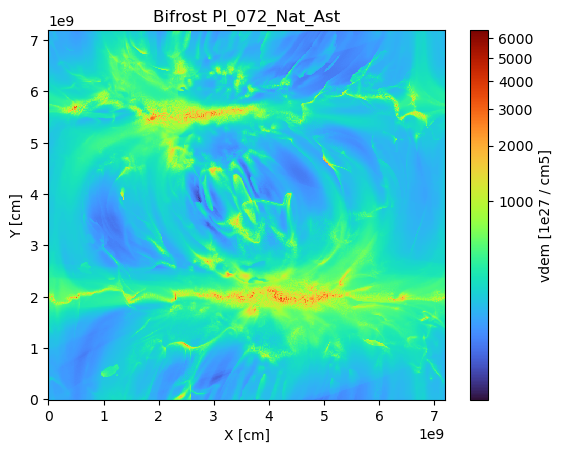

In [17]:
vdem_cut.vdem.sum(dim=['logT','vdop']).T.plot(cmap='turbo', norm=colors.PowerNorm(0.3))
plt.title('Bifrost Pl_072_Nat_Ast')

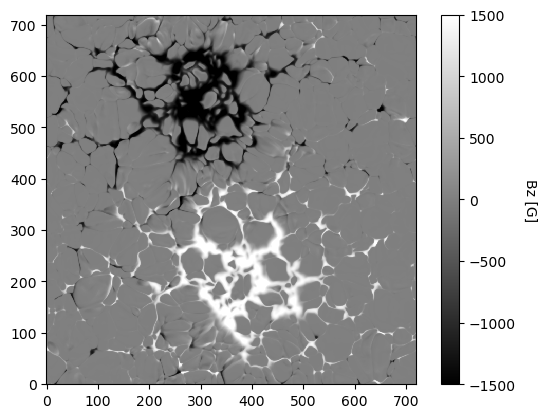

In [34]:
b_z_pl_72 = np.load(vdem_dir+'Bz_z=0.15_072.npy')
plt.imshow(b_z_pl_72*1121, cmap='gray',origin='lower',interpolation='nearest',vmax=1500,vmin=-1500)

cbar = plt.colorbar()
cbar.set_label('Bz [G]', rotation=270, labelpad=15)

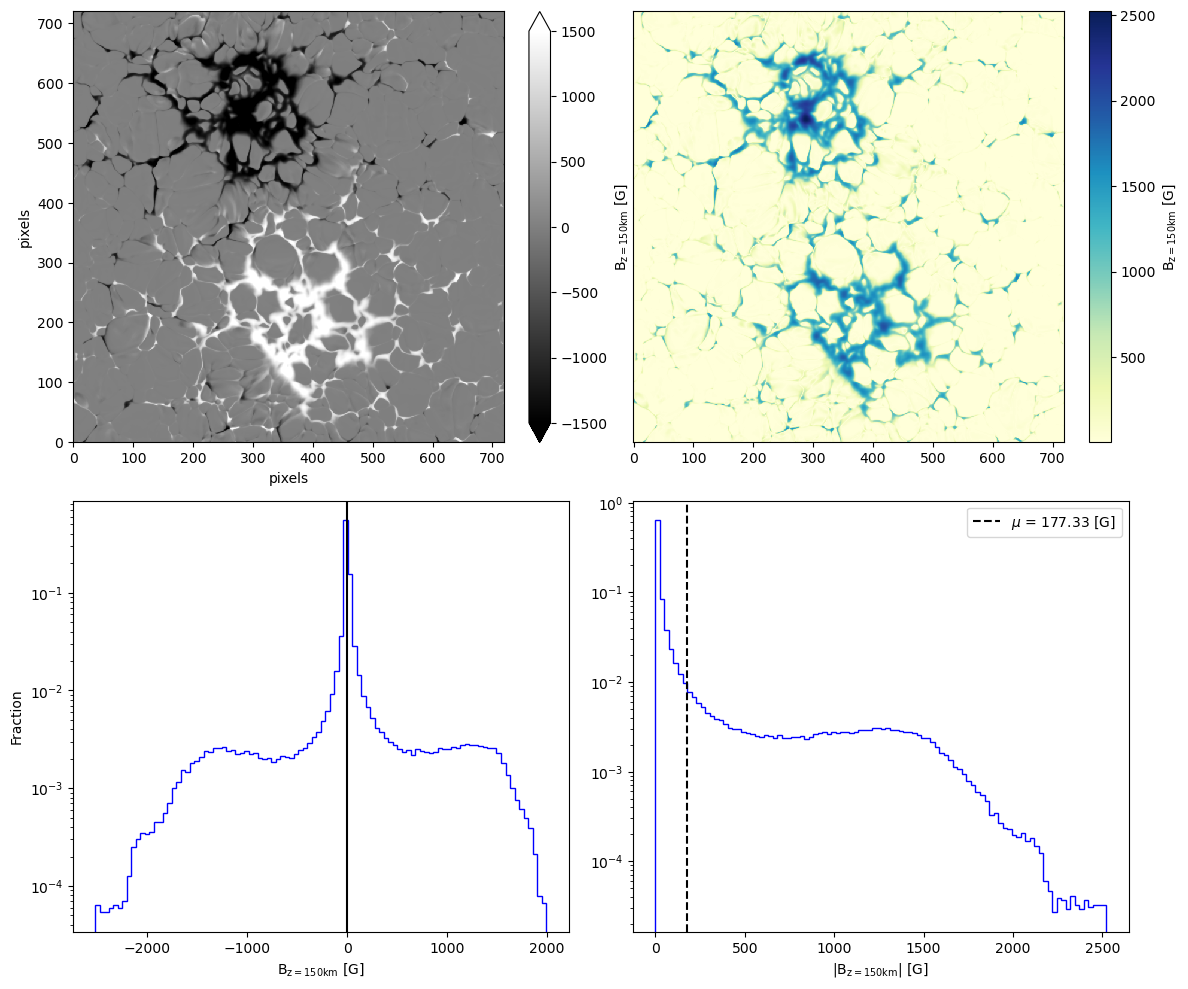

In [85]:
fig, ax =plt.subplots(ncols=2,nrows=2, figsize=(12,10))
ax = ax.ravel()

im = ax[0].imshow(b_z_pl_72*1121, cmap='gray',origin='lower',interpolation='nearest',vmax=1500,vmin=-1500)
cbar = fig.colorbar(im, ax=ax[0],fraction=0.08,extend='both')
cbar.set_label(r'B$_{\mathrm{z=150 km}}$ [G]')
ax[0].set_ylabel('pixels')
ax[0].set_xlabel('pixels')

im = ax[1].imshow(np.abs(b_z_pl_72*1121), cmap='YlGnBu',origin='lower',interpolation='nearest')
cbar = fig.colorbar(im, ax=ax[1],fraction=0.08)
cbar.set_label(r'B$_{\mathrm{z=150 km}}$ [G]')
ax[1].yaxis.set_visible(False)

ax[2].hist(b_z_pl_72.flatten()*1121, bins=100, color='blue',histtype='step', alpha=1, density=False,
           weights=np.ones(len(b_z_pl_72.ravel())) / len(b_z_pl_72.ravel()))
ax[2].set_xlabel(r'B$_{\mathrm{z=150 km}}$ [G]')
ax[2].set_ylabel('Fraction')
ax[2].set_yscale('log')
ax[2].axvline(0, color='black', linestyle='-')
# ax[2].axis('off')
# ax[2].yaxis.set_visible(False)

ax[3].hist(np.abs(b_z_pl_72.flatten()*1121), bins=100, color='blue',histtype='step', alpha=1, density=False,
           weights=np.ones(len(b_z_pl_72.ravel())) / len(b_z_pl_72.ravel()))
ax[3].set_xlabel(r'|B$_{\mathrm{z=150 km}}$| [G]')
# ax[3].set_ylabel('Fraction')
ax[3].set_yscale('log')
ax[3].axvline(x=np.mean(np.abs(b_z_pl_72.flatten()*1121)), color='black', linestyle='--', label=r'$\mu$ = {:.2f} [G]'.format(np.mean(np.abs(b_z_pl_72.flatten()*1121))))
ax[3].legend()
plt.tight_layout()

In [23]:
new_vdem_dir = '/Users/souvikb/MUSE_outputs/vdems/vdems_bifrost_164_hion/'
zarr_file = os.path.join(new_vdem_dir, "vdem_164.zarr")
new_vdem = xr.open_zarr(zarr_file)
new_vdem
aia_resp = xr.open_zarr(os.path.join(os.environ['RESPONSE'], 'aia_resp_DN_Jun18.zarr')).compute()
aia_resp
new_vdem_cut = new_vdem.sel(logT=aia_resp.logT, method = "nearest")
new_vdem_cut = new_vdem_cut.compute()
new_vdem_cut

<xarray.Dataset>
Dimensions:  (logT: 26, vdop: 28, x: 768, y: 768)
Coordinates:
  * logT     (logT) float64 4.4 4.505 4.61 4.714 4.819 ... 6.495 6.6 6.6 6.6 6.6
  * vdop     (vdop) float64 -70.0 -60.0 -50.0 -40.0 ... 170.0 180.0 190.0 200.0
  * x        (x) float64 0.0 3.125e+06 6.25e+06 ... 2.394e+09 2.397e+09
  * y        (y) float64 0.0 3.125e+06 6.25e+06 ... 2.394e+09 2.397e+09
Data variables:
    vdem     (logT, vdop, x, y) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    HISTORY:       ['from_hel2vdem(snap=164, dopaxis=dopaxis, lgtaxis=lgtaxis...
    date created:  02-Jun-2025

Text(0.5, 1.0, 'Bifrost Pl_164_hion')

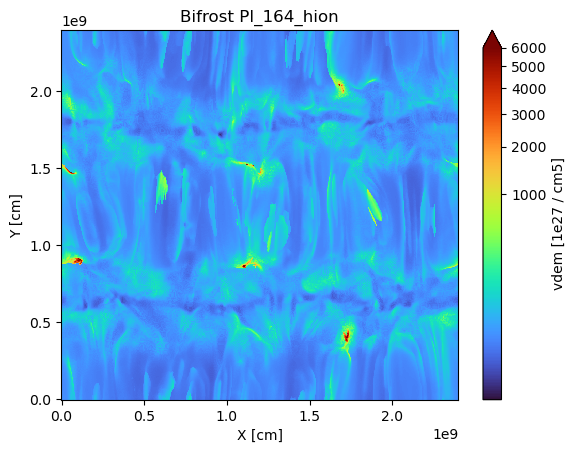

In [25]:
new_vdem_cut.vdem.sum(dim=['logT','vdop']).T.plot(cmap='turbo', norm=colors.PowerNorm(0.3,vmax=6e3))
plt.title('Bifrost Pl_164_hion')